# 1. Packages and Functions

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk2
import biosppy as bs
# import biobss as bo
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from copy import deepcopy
import os
import pandas as pd
from tqdm import tqdm
from collections import Counter
plt.rcParams['figure.figsize'] = [20, 5]  # Bigger images
plt.rcParams['font.size']= 14
pd.set_option('display.max_columns', None)

In [7]:
def plot_ecg(signal, peaks=None, title="ECG"):
    colors = ["#9F0162", "#009F81", "#FF5AAF", "#00FCCF", "#8400CD", "#008DF9", "#00C2F9", "#FFB2FD", "#A40122", "#E20134", "#FF6E3A", "#FFC33B"]
    plt.plot(signal)
    plt.title(title)
    legend = ["Signal"]
    if peaks is not None:
        for clr, (peak_name, peak_points) in enumerate(peaks.items()):
            print(peak_name, peak_points)
            plt.scatter(peak_points, signal[peak_points], s=200, c=colors[clr % len(colors)], marker='.')
            legend.append(peak_name)
    plt.legend(legend, loc="upper right")
    plt.show()

def plot_multiple_ecg(signals, titles):
    fig, axs = plt.subplots(len(signals))
    for i, signal in enumerate(signals):
        axs[i].plot(signal)
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel(titles[i])
    for ax in axs.flat:
        ax.label_outer()
    fig.savefig("figs/denoised", dpi=500, transparent=True)

# 2. Get Data

In [3]:
data_path = "./data/"
comparison_folder = "./comparisons/"
signals = np.load(data_path + "signals.npy", allow_pickle=True)
labels = np.load(data_path + "labels.npy", allow_pickle=True)
r_peaks = np.load(data_path + "peaks.npy", allow_pickle=True)
likelihoods = np.load(data_path + "likelihoods.npy", allow_pickle=True)
sr = 100

r_peaks [2, 100, 203, 301, 407, 516, 624, 730, 826]


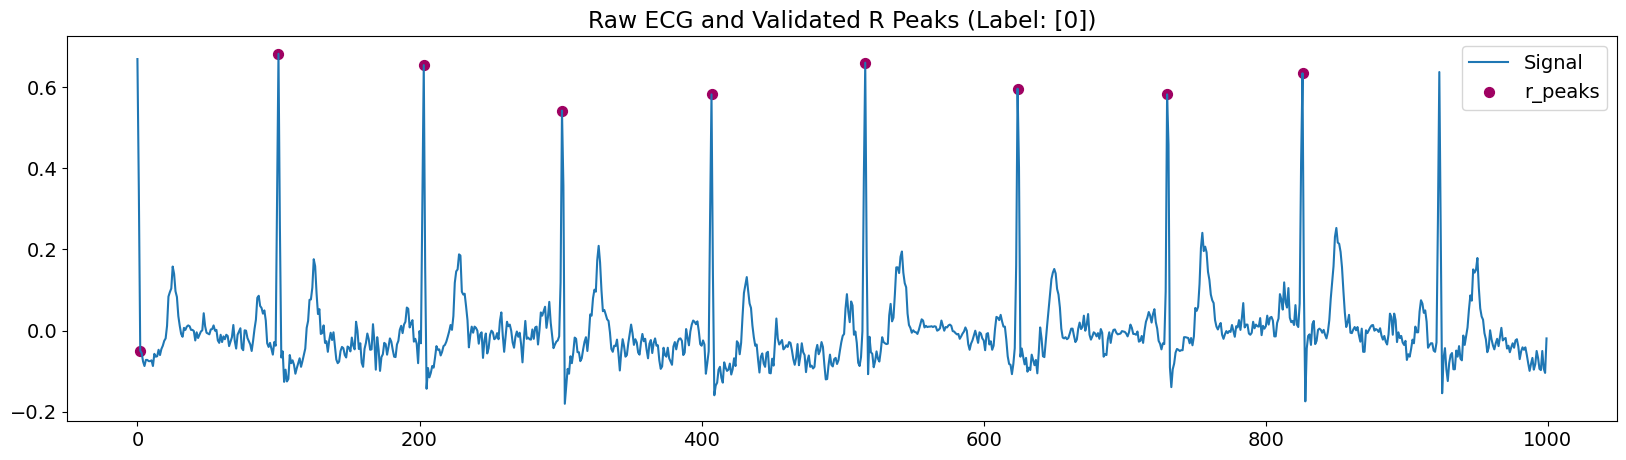

In [8]:
# np.random.seed(42)
idx = np.random.randint(0, signals.shape[0])
signal = signals[idx, :, 0]
signal_peaks = {"r_peaks": r_peaks[idx]}
plot_ecg(signal, signal_peaks, "Raw ECG and Validated R Peaks (Label: " + str(labels[idx]) +")")

# 3. Denoising

In [ ]:
methods = ["Raw", "Neurokit", "Biosppy", "pantompkins1985", "hamilton2002", "elgendi2010", "koka2022"]
cleaned_signals = [signal]
for method in methods[1:]:
    cleaned_signals.append(nk2.ecg_clean(signal, sampling_rate=sr, method=method))

In [ ]:
# plot_ecg(signal, title="Raw")
# plot_ecg(nk2.ecg_clean(signal, sampling_rate=sr, method="neurokit"), title="Cleaned (Neurokit)")
# plot_ecg(nk2.ecg_clean(signal, sampling_rate=sr, method="biosppy"), title="Cleaned (Biosppy-nk)")
# plot_ecg(bs.signals.ecg.ecg(signal, sampling_rate=sr, show=False)[1], title="Cleaned (Biosppy-org)")
# plot_ecg(nk2.ecg_clean(signal, sampling_rate=sr, method="pantompkins1985"), title="Cleaned (pantompkins1985)")
# plot_ecg(nk2.ecg_clean(signal, sampling_rate=sr, method="hamilton2002"), title="Cleaned (hamilton2002)")
# plot_ecg(nk2.ecg_clean(signal, sampling_rate=sr, method="elgendi2010"), title="Cleaned (elgendi2010)")
# plot_ecg(nk2.ecg_clean(signal, sampling_rate=sr, method="koka2022"), title="Cleaned (koka2022)")
plot_multiple_ecg(cleaned_signals, titles=methods)

# 4. Feature Engineering Method Comparison

### 4.1 R Peak Detection

In [ ]:
methods_denoising = ["Raw", "Neurokit", "Biosppy", "pantompkins1985", "hamilton2002", "elgendi2010", "koka2022"]
methods_R_detection = ["Neurokit", "pantompkins1985", "hamilton2002", "zong2003", "martinez2004", "christov2004", "elgendi2010","kalidas2017", "nabian2018", "rodrigues2021", "koka2022", "promac"]
promac_methods=[
        "neurokit",
        "ssf",
        "zong",
        "elgendi",
        "kalidas",
        "martinez",
        "rodrigues",
    ]
kwargs = {'promac_methods': promac_methods}
R_info_template = {
    "MSE": [],
    "MAE": [],
    "Correct R #": [],
    "Detected R #": [],
    "TP": [],
    "FP": [],
    "Performance": [],
    "Acc": [],
    "Err": [],
    "Match": [],
    "Deviation": [],
    "Mean deviation": [],
    "Std deviation": [],
    "mean_ref_ibi": [],
    "std_ref_ibi": [],
    "mean_test_ibi": [],
    "std_test_ibi": [],
    "Label": [],
    "Likelihoods": []
}
R_info = {}
for cleaner in methods_denoising:
    for detector in methods_R_detection:
        for ca in [True, False]:
            name = cleaner + "+" + detector
            if ca:
                name += "+Kubios"
            info = deepcopy(R_info_template)
            print("Starting " + name)
            for signal, r_correct, label, likelihood in tqdm(zip(signals, r_peaks, labels, likelihoods)):
                signal = signal[:,0]
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    cleaned = nk2.ecg_clean(signal, sampling_rate=sr, method=cleaner) if cleaner != "Raw" else signal.copy()
                    if detector == "promac":
                        r_detected = nk2.ecg_peaks(cleaned, sr, detector, ca, **kwargs)[1]["ECG_R_Peaks"]
                    else:
                        r_detected = nk2.ecg_peaks(cleaned, sr, detector, ca)[1]["ECG_R_Peaks"]

                if(len(r_detected) == len(r_correct)):
                    info['MSE'].append(mean_squared_error(r_correct, r_detected))
                    info['MAE'].append(mean_absolute_error(r_correct, r_detected))
                else:
                    info['MSE'].append(np.Inf)
                    info['MAE'].append(np.Inf)

                info['Correct R #'].append(len(r_correct))
                info['Detected R #'].append(len(r_detected))
                info['Label'].append(str(label))
                info['Likelihoods'].append(str(likelihood))
                try:
                    comparison = dict(bs.signals.ecg.compare_segmentation(r_correct, r_detected, sr))
                    info['TP'].append(comparison['TP'])
                    info['FP'].append(comparison['FP'])
                    info['Performance'].append(comparison['performance'])
                    info['Acc'].append(comparison['acc'])
                    info['Err'].append(comparison['err'])
                    info['Match'].append(str(comparison['match']))
                    info['Deviation'].append(str(comparison['deviation']))
                    info['Mean deviation'].append(comparison['mean_deviation'])
                    info['Std deviation'].append(comparison['std_deviation'])
                    info["mean_ref_ibi"].append(comparison["mean_ref_ibi"])
                    info["std_ref_ibi"].append(comparison["std_ref_ibi"])
                    info["mean_test_ibi"].append(comparison["mean_test_ibi"])
                    info["std_test_ibi"].append(comparison["std_test_ibi"])
                except ZeroDivisionError:
                    info['TP'].append(0)
                    info['FP'].append(0)
                    info['Performance'].append(0)
                    info['Acc'].append(0)
                    info['Err'].append(0)
                    info['Match'].append(str(0))
                    info['Deviation'].append(str(0))
                    info['Mean deviation'].append(0)
                    info['Std deviation'].append(0)
                    info["mean_ref_ibi"].append(0)
                    info["std_ref_ibi"].append(0)
                    info["mean_test_ibi"].append(0)
                    info["std_test_ibi"].append(0)
            df = pd.DataFrame.from_dict(info)
            display(df.head())
            df.to_csv(name + '.csv', index=False)
            R_info[name] = info

#### 4.1.1 Compare R Peak Detection Algorithms

In [ ]:

metric_files = os.listdir(comparison_folder)

# str_labels = list(map(str, labels))
# str_likelihoods = list(map(str, likelihoods))


# for metric_file in tqdm(metric_files):
#     df = pd.read_csv(os.path.join(comparison_folder, metric_file))
#     df['Label'] = str_labels
#     df['Likelihoods'] = str_likelihoods
#     df.to_csv(os.path.join(comparison_folder, metric_file), index=False)

nk_promac_ca = pd.read_csv(os.path.join(comparison_folder + "koka2022+rodrigues2021.csv"))
display(nk_promac_ca[:10])
print("Neurokit+promac+Kubios.csv"[:-4])
Exactly_matched_rows = nk_promac_ca[nk_promac_ca["Correct R #"] == nk_promac_ca["Detected R #"]]
print(len(Exactly_matched_rows))
print(Exactly_matched_rows['MSE'].mean())
print(Exactly_matched_rows['MSE'].max())
print(Exactly_matched_rows['MSE'].min())
print(Exactly_matched_rows['MAE'].mean())
print(Exactly_matched_rows['MAE'].max())
print(Exactly_matched_rows['MAE'].min())
print(nk_promac_ca['Correct R #'].mean())
print(nk_promac_ca['Detected R #'].mean())
print(nk_promac_ca['TP'].mean())
print(nk_promac_ca['FP'].mean())
print(nk_promac_ca['Performance'].mean())
print(nk_promac_ca['Acc'].mean())
print(nk_promac_ca['Err'].mean())
print(nk_promac_ca['Mean deviation'].mean())
print(nk_promac_ca['Std deviation'].mean())
print(nk_promac_ca['mean_ref_ibi'].mean())
print(nk_promac_ca['mean_ref_ibi'].max())
print(nk_promac_ca['mean_ref_ibi'].min())
print(nk_promac_ca['std_ref_ibi'].mean())
print(nk_promac_ca['std_ref_ibi'].max())
print(nk_promac_ca['std_ref_ibi'].min())
print(nk_promac_ca['mean_test_ibi'].mean())
print(nk_promac_ca['mean_test_ibi'].max())
print(nk_promac_ca['mean_test_ibi'].min())
print(nk_promac_ca['std_test_ibi'].mean())
print(nk_promac_ca['std_test_ibi'].max())
print(nk_promac_ca['std_test_ibi'].min())

* Name of the method
* Exact Matches: # of signals where detected R # == correct R #
* Mean MSE: mean of exact matched signals
* Max MSE
* Min MSE
* Mean MAE: mean of exact matched signals
* Max MAE
* Min MAE
* Mean Correct R #: all signals
* Mean Detected R #: all signals

---- Below can be set to 0 because of the zerodivision error
* Mean TP: mean of correctly detected peaks with tolerence of +- 0.05 seconds
* Mean FP: mean of incrorrectly detected peaks at the beginning (intermediate incorrect detections can be removed by min RR check)
* Mean Performance: mean of (TP/ Correct R #)
* Mean Acc: mean of (TP/ (TP+FP))
* Mean Err: mean of (FP / (TP+FP))
* Mean mean_deviation:  Mean error (seconds)
* Mean std_deviation: Standard deviation of error (seconds)
* Mean mean_ref_ibi: Mean of the reference interbeat intervals (seconds)
* Min mean_ref_ibi: Mean of the reference interbeat intervals (seconds)
* Mean std_ref_ibi: Standard deviation of the reference interbeat intervals (seconds)
* Min std_ref_ibi: Standard deviation of the reference interbeat intervals (seconds)
* Mean mean_test_ibi: Mean of the test interbeat intervals (seconds)
* Min mean_test_ibi: Mean of the test interbeat intervals (seconds)
* Mean std_test_ibi: Standard deviation of the test interbeat intervals (seconds)
* Min std_test_ibi: Standard deviation of the test interbeat intervals (seconds)

In [5]:
stats_template = {
    "Name": [],
    "Exact Matches #": [],
    "Mean MSE": [],
    "Max MSE": [],
    "Min MSE": [],
    "Mean MAE": [],
    "Max MAE": [],
    "Min MAE": [],
    "Mean Correct R #": [],
    "Mean Detected R #": [],
    "Mean TP": [],
    "Mean FP": [],
    "Mean Performance": [],
    "Mean Acc": [],
    "Mean Err": [],
    "Mean mean_deviation": [],
    "Mean std_deviation": [],
    "Mean mean_ref_ibi": [],
    "Max mean_ref_ibi": [],
    "Min mean_ref_ibi": [],
    "Mean std_ref_ibi": [],
    "Max std_ref_ibi": [],
    "Min std_ref_ibi": [],
    "Mean mean_test_ibi": [],
    "Max mean_test_ibi": [],
    "Min mean_test_ibi": [],
    "Mean std_test_ibi": [],
    "Max std_test_ibi": [],
    "Min std_test_ibi": []
}
def create_stats(metric_files, name="stats", label_filter = None):
    stats = deepcopy(stats_template)
    for metric_file in tqdm(metric_files):
        stats['Name'].append(metric_file[:-4])
        df = pd.read_csv(os.path.join(comparison_folder, metric_file))

        if label_filter is not None:
            df = df[label_filter == df['Label']]
        
        exactly_matched_rows = df[df["Correct R #"] == df["Detected R #"]]
        stats['Exact Matches #'].append(len(exactly_matched_rows))
        
        stats['Mean MSE'].append(exactly_matched_rows['MSE'].mean())
        stats['Max MSE'].append(exactly_matched_rows['MSE'].max())
        stats['Min MSE'].append(exactly_matched_rows['MSE'].min())

        stats['Mean MAE'].append(exactly_matched_rows['MAE'].mean())
        stats['Max MAE'].append(exactly_matched_rows['MAE'].max())
        stats['Min MAE'].append(exactly_matched_rows['MAE'].min())

        stats['Mean Correct R #'].append(df['Correct R #'].mean())
        stats['Mean Detected R #'].append(df['Detected R #'].mean())
        stats['Mean TP'].append(df['TP'].mean())
        stats['Mean FP'].append(df['FP'].mean())
        
        stats['Mean Performance'].append(df['Performance'].mean())
        stats['Mean Acc'].append(df['Acc'].mean())
        stats['Mean Err'].append(df['Err'].mean())

        stats['Mean mean_deviation'].append(df['Mean deviation'].mean())
        stats['Mean std_deviation'].append(df['Std deviation'].mean())

        stats['Mean mean_ref_ibi'].append(df['mean_ref_ibi'].mean())
        stats['Max mean_ref_ibi'].append(df['mean_ref_ibi'].max())
        stats['Min mean_ref_ibi'].append(df['mean_ref_ibi'].min())

        stats['Mean std_ref_ibi'].append(df['std_ref_ibi'].mean())
        stats['Max std_ref_ibi'].append(df['std_ref_ibi'].max())
        stats['Min std_ref_ibi'].append(df['std_ref_ibi'].min())

        stats['Mean mean_test_ibi'].append(df['mean_test_ibi'].mean())
        stats['Max mean_test_ibi'].append(df['mean_test_ibi'].max())
        stats['Min mean_test_ibi'].append(df['mean_test_ibi'].min())

        stats['Mean std_test_ibi'].append(df['std_test_ibi'].mean())
        stats['Max std_test_ibi'].append(df['std_test_ibi'].max())
        stats['Min std_test_ibi'].append(df['std_test_ibi'].min())

    df_stats = pd.DataFrame.from_dict(stats)
    df_stats.to_csv(os.path.join("./comparison_stats/", name + '.csv'), index=False)

create_stats(metric_files)
create_stats(metric_files, "Healthy_stats", "[0]")
create_stats(metric_files, "MI_stats", "[1]")
create_stats(metric_files, "STEMI_stats", "[1, 2]")

100%|██████████| 182/182 [01:00<00:00,  3.01it/s]


In [6]:
df_stats = pd.read_csv(os.path.join("./comparison_stats", "stats.csv"))
# df_stats.sort_values(by=['Mean Performance'], ascending=False)[["Name", 'Mean Performance', 
#                    'Mean Acc', 'Mean Err',
#                    'Mean Correct R #', 'Mean Detected R #','Mean TP', 'Mean FP']].iloc[:10]
df_stats.sort_values(by=['Mean Performance'], ascending=False).iloc[:20]

,Name,Exact Matches #,Mean MSE,Max MSE,Min MSE,Mean MAE,Max MAE,Min MAE,Mean Correct R #,Mean Detected R #,Mean TP,Mean FP,Mean Performance,Mean Acc,Mean Err,Mean mean_deviation,Mean std_deviation,Mean mean_ref_ibi,Max mean_ref_ibi,Min mean_ref_ibi,Mean std_ref_ibi,Max std_ref_ibi,Min std_ref_ibi,Mean mean_test_ibi,Max mean_test_ibi,Min mean_test_ibi,Mean std_test_ibi,Max std_test_ibi,Min std_test_ibi
179,Raw+rodrigues2021,2784,141.090610,27342.700000,0.0,2.191148,154.300000,0.0,12.1588,14.672446,12.261731,1.065593,1.011206,0.917021,0.082979,0.006915,0.005875,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846824,1.490000,0.315000,0.048230,0.508547,0.0
127,Neurokit+rodrigues2021,3459,103.214613,17132.090909,0.0,1.677087,121.363636,0.0,12.1588,13.994496,12.269024,1.025320,1.011110,0.919997,0.080003,0.005951,0.005585,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846245,1.490000,0.314667,0.046923,0.508547,0.0
101,koka2022+rodrigues2021,2755,143.779462,27342.700000,0.0,2.235406,154.300000,0.0,12.1588,14.704325,12.246915,1.073299,1.010098,0.916255,0.083745,0.007074,0.005933,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846951,1.490000,0.315000,0.048463,0.509117,0.0
23,Biosppy+rodrigues2021,2838,155.639017,17698.692308,0.0,2.327074,126.538462,0.0,12.1588,14.629375,12.246915,1.075455,1.010028,0.916304,0.083696,0.006856,0.005867,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846847,1.490000,0.315000,0.048172,0.528750,0.0
153,pantompkins1985+rodrigues2021,3177,97.591457,18511.153846,0.0,2.319023,128.076923,0.0,12.1588,13.939636,12.086693,1.045457,0.996455,0.916916,0.083084,0.011586,0.004869,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.847647,1.490000,0.315000,0.046873,0.509117,0.0
75,hamilton2002+rodrigues2021,2734,131.052724,19425.727273,0.0,2.782411,128.272727,0.0,12.1588,14.047429,11.992019,1.076740,0.989462,0.914056,0.085944,0.013236,0.005646,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.848983,1.490000,0.310000,0.048679,0.664680,0.0
125,Neurokit+promac_optimized,13670,146.091971,19187.142857,0.0,2.166964,136.285714,0.0,12.1588,12.542911,11.927526,0.304344,0.981463,0.972951,0.027049,0.004016,0.003559,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846713,1.486667,0.328966,0.046408,0.514908,0.0
178,Raw+rodrigues2021+Kubios,4311,89.029765,27342.700000,0.0,1.752162,154.300000,0.0,12.1588,14.429797,11.897023,1.101601,0.980355,0.912239,0.087761,0.006819,0.005711,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.847922,1.490000,0.315000,0.049401,0.700036,0.0
100,koka2022+rodrigues2021+Kubios,4274,91.860287,27342.700000,0.0,1.787754,154.300000,0.0,12.1588,14.463236,11.880694,1.110087,0.979097,0.911391,0.088609,0.006976,0.005764,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.848002,1.490000,0.315000,0.049633,0.700036,0.0
22,Biosppy+rodrigues2021+Kubios,4435,102.639533,17698.692308,0.0,1.874136,126.538462,0.0,12.1588,14.385303,11.880464,1.112518,0.979057,0.911392,0.088608,0.006760,0.005696,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.847859,1.490000,0.315000,0.049112,0.700036,0.0


In [7]:
df_stats.sort_values(by=['Mean Acc'], ascending=False).iloc[:20]

,Name,Exact Matches #,Mean MSE,Max MSE,Min MSE,Mean MAE,Max MAE,Min MAE,Mean Correct R #,Mean Detected R #,Mean TP,Mean FP,Mean Performance,Mean Acc,Mean Err,Mean mean_deviation,Mean std_deviation,Mean mean_ref_ibi,Max mean_ref_ibi,Min mean_ref_ibi,Mean std_ref_ibi,Max std_ref_ibi,Min std_ref_ibi,Mean mean_test_ibi,Max mean_test_ibi,Min mean_test_ibi,Mean std_test_ibi,Max std_test_ibi,Min std_test_ibi
119,Neurokit+Neurokit,13690,814.611749,19542.000000,0.0,9.831041,139.714286,0.0,12.1588,11.935416,11.658273,0.039723,0.960202,0.995934,0.004020,0.003946,0.003433,0.845254,1.49,0.00,0.045796,0.526318,0.0,0.846806,1.486667,0.000000,0.046116,0.516188,0.0
118,Neurokit+Neurokit+Kubios,13725,808.714707,19542.000000,0.0,9.890196,139.714286,0.0,12.1588,11.937939,11.552681,0.040503,0.951823,0.995860,0.004094,0.004139,0.003714,0.845254,1.49,0.00,0.045796,0.526318,0.0,0.847036,1.486667,0.000000,0.045106,0.671751,0.0
171,Raw+Neurokit,13468,839.724399,19579.571429,0.0,10.133815,139.857143,0.0,12.1588,11.952204,11.657263,0.044402,0.959954,0.995665,0.004289,0.003817,0.003438,0.845243,1.49,0.00,0.045796,0.526318,0.0,0.846565,1.487500,0.000000,0.046059,0.514908,0.0
170,Raw+Neurokit+Kubios,13560,832.627188,19579.571429,0.0,10.161941,139.857143,0.0,12.1588,11.949635,11.552360,0.044585,0.951686,0.995619,0.004335,0.004015,0.003723,0.845243,1.49,0.00,0.045796,0.526318,0.0,0.846756,1.490000,0.000000,0.045016,0.671751,0.0
15,Biosppy+Neurokit,13212,879.663023,16874.142857,0.0,10.633371,129.857143,0.0,12.1588,11.984725,11.647493,0.050319,0.959062,0.995015,0.004985,0.003851,0.003440,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846493,1.487500,0.314828,0.046229,0.512182,0.0
93,koka2022+Neurokit,13201,877.386602,16874.142857,0.0,10.623835,129.857143,0.0,12.1588,11.984404,11.645704,0.050273,0.958941,0.994989,0.005011,0.003847,0.003448,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846543,1.487500,0.314828,0.046239,0.512182,0.0
14,Biosppy+Neurokit+Kubios,13379,863.837598,16874.142857,0.0,10.553293,129.857143,0.0,12.1588,11.974130,11.543874,0.050686,0.950952,0.994949,0.005051,0.004043,0.003723,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846697,1.485000,0.314828,0.045324,0.671751,0.0
92,koka2022+Neurokit+Kubios,13371,858.943193,16874.142857,0.0,10.515443,129.857143,0.0,12.1588,11.972983,11.542085,0.050732,0.950821,0.994919,0.005081,0.004041,0.003736,0.845279,1.49,0.31,0.045796,0.526318,0.0,0.846677,1.485000,0.314828,0.045282,0.671751,0.0
145,pantompkins1985+Neurokit,13806,744.240361,19684.000000,0.0,9.077351,140.285714,0.0,12.1588,11.907435,11.622999,0.051741,0.957870,0.994851,0.005104,0.005768,0.004433,0.845261,1.49,0.00,0.045796,0.526318,0.0,0.847708,1.490000,0.000000,0.046607,0.537401,0.0
144,pantompkins1985+Neurokit+Kubios,13863,733.151763,19684.000000,0.0,9.056879,140.285714,0.0,12.1588,11.907206,11.524609,0.052108,0.950066,0.994821,0.005133,0.005870,0.004623,0.845261,1.49,0.00,0.045796,0.526318,0.0,0.847886,1.490000,0.000000,0.045712,0.657609,0.0


#### 4.1.2 The Ultimate R Detector

In [100]:
class Detector(object):
    def __init__(self, sr = 100, method_denoise = "Neurokit", method_rpeak = "Neurokit", correct_artifacts = False):
        self.sr = sr
        self.method_denoise = method_denoise
        self.method_rpeak = method_rpeak
        self.correct_artifacts = correct_artifacts
    
    def denoise(self, signal):
        return nk2.ecg.ecg_clean(signal, sampling_rate=self.sr, method=self.method_denoise)
    
    def correct_rpeaks(self, signal, rpeaks, tolerance = 0.05):
        return bs.signals.ecg.correct_rpeaks(signal, rpeaks, self.sr, tolerance)[0]
    
    def detect_rpeaks(self, signal, correct_peaks = False, tolerance = 0.05, return_denoised_signal = False):
        # fixed, is_inverted = nk2.ecg.ecg_invert(signal, sampling_rate = self.sr, show=False)
        # if is_inverted:
        #     signal = fixed
        denoised = self.denoise(signal)

        rpeaks = nk2.ecg.ecg_peaks(denoised, sampling_rate=self.sr, method=self.method_rpeak, correct_artifacts=self.correct_artifacts)[1]["ECG_R_Peaks"]

        if correct_peaks:
            rpeaks = self.correct_rpeaks(signal, rpeaks, tolerance)
        
        if return_denoised_signal:
            return denoised, rpeaks

        return rpeaks
    
    def detect_fiducials(self, signal):
        denoised, rpeaks = self.detect_rpeaks(signal, return_denoised_signal=True)

        _, fiducials = nk2.ecg.ecg_delineate(denoised, rpeaks, sampling_rate=self.sr)

        fiducials["ECG_R_Peaks"] = rpeaks

        return fiducials
    
    def process(self, signal_12lead):
        """
        Inspired by Biosppy ecg
        """
        # Denoise 12-lead ECG signal
        for i in range(12):
            signal_12lead[:, i] = self.denoise(signal_12lead[:, i])
        
        # Detect R peaks using lead I
        rpeaks = self.detect_rpeaks(signal_12lead[:, 0])

        # Heart beats
        templates, rpeaks = bs.signals.ecg.extract_heartbeats(signal = signal_12lead[:, 0], rpeaks = rpeaks, sampling_rate = self.sr, before = 0.2, after = 0.4)

        # Heart rate
        hr_idx, hr = bs.tools.get_heart_rate(beats = rpeaks, sampling_rate = self.sr, smooth = True, size = 3)

        # time vectors
        lenght = len(signal)
        T = (lenght - 1) / self.sr
        ts = np.linspace(0, T, lenght, endpoint=True)
        ts_hr = ts[hr_idx]
        ts_tmpl = np.linspace(-0.2, 0.4, templates.shape[1], endpoint=False)
        
        names = ("ts", "filtered", "rpeaks", "templates_ts", "templates", "heart_rate_ts", "heart_rate")
        
        # For P wave features use lead II among (II, V1, aVF)
        templatesP, _ = bs.signals.ecg.extract_heartbeats(signal = signal_12lead[:, 1], rpeaks = rpeaks, sampling_rate = self.sr, before = 0.2, after = 0.4)
        argsP = (ts, signal_12lead[:, 1], rpeaks, ts_tmpl, templatesP, ts_hr, hr)
        processP = bs.utils.ReturnTuple(argsP, names)
        P_Peaks, P_Onsets, P_Offsets = bs.signals.ecg.getPPositions(processP)

        # For Q wave features use lead I among (I, aVL)
        argsQ = (ts, signal_12lead[:, 0], rpeaks, ts_tmpl, templates, ts_hr, hr)
        processQ = bs.utils.ReturnTuple(argsQ, names)
        Q_Peaks, Q_Onsets = bs.signals.ecg.getQPositions(processQ)

        # For S wave features use lead V1 among (V1, V2, V3)
        templatesS, _ = bs.signals.ecg.extract_heartbeats(signal = signal_12lead[:, 6], rpeaks = rpeaks, sampling_rate = self.sr, before = 0.2, after = 0.4)
        argsS = (ts, signal_12lead[:, 6], rpeaks, ts_tmpl, templatesS, ts_hr, hr)
        processS = bs.utils.ReturnTuple(argsS, names)
        S_Peaks, S_Offsets = bs.signals.ecg.getSPositions(processS)

        # For T wave features use lead V4 among (V4, V5)
        templatesT, _ = bs.signals.ecg.extract_heartbeats(signal = signal_12lead[:, 9], rpeaks = rpeaks, sampling_rate = self.sr, before = 0.2, after = 0.4)
        argsT = (ts, signal_12lead[:, 9], rpeaks, ts_tmpl, templatesT, ts_hr, hr)
        processT = bs.utils.ReturnTuple(argsT, names)
        T_Peaks, T_Onsets, T_Offsets = bs.signals.ecg.getTPositions(processT)

        fiducials = {
            "R_Peaks": rpeaks,
            "P_Peaks": P_Peaks,
            "P_Onsets": P_Onsets,
            "P_Offsets": P_Offsets,
            "Q_Peaks": Q_Peaks,
            "Q_Onsets": Q_Onsets,
            "S_Peaks": S_Peaks,
            "S_Offsets": S_Offsets,
            "T_Peaks": T_Peaks,
            "T_Onsets": T_Onsets,
            "T_Offsets": T_Offsets
        }

        return templates, fiducials
        
    def get_stats(self, name, label_filter = None):
        stats = {
            "Name": [],
            "Exact Matches #": [],
            "Mean MSE": [],
            "Max MSE": [],
            "Min MSE": [],
            "Mean MAE": [],
            "Max MAE": [],
            "Min MAE": [],
            "Mean Correct R #": [],
            "Mean Detected R #": [],
            "Mean TP": [],
            "Mean FP": [],
            "Mean Performance": [],
            "Mean Acc": [],
            "Mean Err": [],
            "Mean mean_deviation": [],
            "Mean std_deviation": [],
            "Mean mean_ref_ibi": [],
            "Max mean_ref_ibi": [],
            "Min mean_ref_ibi": [],
            "Mean std_ref_ibi": [],
            "Max std_ref_ibi": [],
            "Min std_ref_ibi": [],
            "Mean mean_test_ibi": [],
            "Max mean_test_ibi": [],
            "Min mean_test_ibi": [],
            "Mean std_test_ibi": [],
            "Max std_test_ibi": [],
            "Min std_test_ibi": []
        }
        stats['Name'].append(name)
        df = pd.read_csv(os.path.join(comparison_folder, name + ".csv"))

        if label_filter is not None:
            df = df[label_filter == df['Label']]
        
        exactly_matched_rows = df[df["Correct R #"] == df["Detected R #"]]
        stats['Exact Matches #'].append(len(exactly_matched_rows))
        
        stats['Mean MSE'].append(exactly_matched_rows['MSE'].mean())
        stats['Max MSE'].append(exactly_matched_rows['MSE'].max())
        stats['Min MSE'].append(exactly_matched_rows['MSE'].min())

        stats['Mean MAE'].append(exactly_matched_rows['MAE'].mean())
        stats['Max MAE'].append(exactly_matched_rows['MAE'].max())
        stats['Min MAE'].append(exactly_matched_rows['MAE'].min())

        stats['Mean Correct R #'].append(df['Correct R #'].mean())
        stats['Mean Detected R #'].append(df['Detected R #'].mean())
        stats['Mean TP'].append(df['TP'].mean())
        stats['Mean FP'].append(df['FP'].mean())
        
        stats['Mean Performance'].append(df['Performance'].mean())
        stats['Mean Acc'].append(df['Acc'].mean())
        stats['Mean Err'].append(df['Err'].mean())

        stats['Mean mean_deviation'].append(df['Mean deviation'].mean())
        stats['Mean std_deviation'].append(df['Std deviation'].mean())

        stats['Mean mean_ref_ibi'].append(df['mean_ref_ibi'].mean())
        stats['Max mean_ref_ibi'].append(df['mean_ref_ibi'].max())
        stats['Min mean_ref_ibi'].append(df['mean_ref_ibi'].min())

        stats['Mean std_ref_ibi'].append(df['std_ref_ibi'].mean())
        stats['Max std_ref_ibi'].append(df['std_ref_ibi'].max())
        stats['Min std_ref_ibi'].append(df['std_ref_ibi'].min())

        stats['Mean mean_test_ibi'].append(df['mean_test_ibi'].mean())
        stats['Max mean_test_ibi'].append(df['mean_test_ibi'].max())
        stats['Min mean_test_ibi'].append(df['mean_test_ibi'].min())

        stats['Mean std_test_ibi'].append(df['std_test_ibi'].mean())
        stats['Max std_test_ibi'].append(df['std_test_ibi'].max())
        stats['Min std_test_ibi'].append(df['std_test_ibi'].min())
        
        df_stats = pd.DataFrame.from_dict(stats)
        display(df_stats)

    def benchmark(self, dataset, save=True, name="Detector"):
        info = {
            "MSE": [],
            "MAE": [],
            "Correct R #": [],
            "Detected R #": [],
            "TP": [],
            "FP": [],
            "Performance": [],
            "Acc": [],
            "Err": [],
            "Match": [],
            "Deviation": [],
            "Mean deviation": [],
            "Std deviation": [],
            "mean_ref_ibi": [],
            "std_ref_ibi": [],
            "mean_test_ibi": [],
            "std_test_ibi": [],
            "Label": [],
            "Likelihoods": []
        }
        for signal, r_correct, label, likelihood in tqdm(dataset):
            signal = signal[:,0]
            r_detected = self.detect_rpeaks(signal)

            if(len(r_detected) == len(r_correct)):
                info['MSE'].append(mean_squared_error(r_correct, r_detected))
                info['MAE'].append(mean_absolute_error(r_correct, r_detected))
            else:
                info['MSE'].append(np.Inf)
                info['MAE'].append(np.Inf)            

            info['Correct R #'].append(len(r_correct))
            info['Detected R #'].append(len(r_detected))
            info['Label'].append(str(label))
            info['Likelihoods'].append(str(likelihood))
            try:
                comparison = dict(bs.signals.ecg.compare_segmentation(r_correct, r_detected, sr))
                info['TP'].append(comparison['TP'])
                info['FP'].append(comparison['FP'])
                info['Performance'].append(comparison['performance'])
                info['Acc'].append(comparison['acc'])
                info['Err'].append(comparison['err'])
                info['Match'].append(str(comparison['match']))
                info['Deviation'].append(str(comparison['deviation']))
                info['Mean deviation'].append(comparison['mean_deviation'])
                info['Std deviation'].append(comparison['std_deviation'])
                info["mean_ref_ibi"].append(comparison["mean_ref_ibi"])
                info["std_ref_ibi"].append(comparison["std_ref_ibi"])
                info["mean_test_ibi"].append(comparison["mean_test_ibi"])
                info["std_test_ibi"].append(comparison["std_test_ibi"])
            except ZeroDivisionError:
                info['TP'].append(0)
                info['FP'].append(0)
                info['Performance'].append(0)
                info['Acc'].append(0)
                info['Err'].append(0)
                info['Match'].append(str(0))
                info['Deviation'].append(str(0))
                info['Mean deviation'].append(0)
                info['Std deviation'].append(0)
                info["mean_ref_ibi"].append(0)
                info["std_ref_ibi"].append(0)
                info["mean_test_ibi"].append(0)
                info["std_test_ibi"].append(0)
                
        df = pd.DataFrame.from_dict(info)
        display(df)
        if save:
            df.to_csv(os.path.join(comparison_folder, name + ".csv"), index=False)

In [101]:
detector = Detector()
idx = np.random.randint(0, signals.shape[0])
signal = signals[idx, :, 0]

rpeaks = detector.detect_rpeaks(signal)
fiducials = detector.detect_fiducials(signal)
signal_peaks = {
    'Q_Peaks': fiducials['ECG_Q_Peaks'],
    'S_Peaks': fiducials['ECG_S_Peaks'],
    'R_Onsets': fiducials['ECG_R_Onsets'],
    'R_Offsets': fiducials['ECG_R_Offsets']
}
plot_ecg(signal, signal_peaks, "ECG " + str(labels[idx]))



IndexError: index 0 is out of bounds for axis 0 with size 0